# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../Yang_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
df_initial = df_initial.drop(columns=['SRR7542864_sorted.bam', 'SRR7542865_sorted.bam', 'SRR7542866_sorted.bam',
                                      'SRR7542867_sorted.bam', 'SRR7542868_sorted.bam', 'SRR7542869_sorted.bam',
                                      'SRR7542870_sorted.bam', 'SRR7542871_sorted.bam', 'SRR7542872_sorted.bam'])
metadata = pd.read_csv(metaPath)
metadata = metadata.drop([9, 10, 11, 12, 13, 14, 15, 16, 17])

In [4]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR7542856_sorted.bam,SRR7542855_sorted.bam,SRR7542860_sorted.bam,SRR7542858_sorted.bam,SRR7542863_sorted.bam,SRR7542861_sorted.bam,SRR7542857_sorted.bam,SRR7542859_sorted.bam,SRR7542862_sorted.bam
Geneid,,,,,,,,,,,,,,
gene-AUO97_RS00010,NZ_CP018664.1,1277,2113,+,837,61,71,83,73,80,39,63,70,58
gene-AUO97_RS00015,NZ_CP018664.1,2164,2769,+,606,22,35,28,45,29,20,36,28,20
gene-AUO97_RS00020,NZ_CP018664.1,3336,3662,+,327,510,583,893,1029,930,574,371,1003,1005
gene-AUO97_RS00025,NZ_CP018664.1,3659,4129,-,471,321,405,482,536,493,298,239,516,519
gene-AUO97_RS00030,NZ_CP018664.1,4293,4655,-,363,927,1808,575,1530,1346,1271,591,1337,1918


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment
0,SRR7542855,RNA-Seq,300,1783399200,PRJNA481979,SAMN09692920,563261783,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409224,GSM3293804,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:36:00Z,1,GSM3293804,"AB1 lysates\, 5min\, replicate 1",SRP154466,AB1,without phage infection control 5min
1,SRR7542856,RNA-Seq,300,1531150200,PRJNA481979,SAMN09692919,477495557,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409225,GSM3293805,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:40:00Z,1,GSM3293805,"AB1 lysates\, 5min\, replicate 2",SRP154466,AB1,without phage infection control 5min
2,SRR7542857,RNA-Seq,300,1629806100,PRJNA481979,SAMN09692918,506658082,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409226,GSM3293806,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:38:00Z,1,GSM3293806,"AB1 lysates\, 5min\, replicate 3",SRP154466,AB1,without phage infection control 5min
3,SRR7542858,RNA-Seq,300,2151654900,PRJNA481979,SAMN09692917,686231832,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409227,GSM3293807,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:38:00Z,1,GSM3293807,"AB1 lysates\, 10min\, replicate 1",SRP154466,AB1,without phage infection control 10min
4,SRR7542859,RNA-Seq,300,2200823400,PRJNA481979,SAMN09692916,744995434,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409228,GSM3293808,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:39:00Z,1,GSM3293808,"AB1 lysates\, 10min\, replicate 2",SRP154466,AB1,without phage infection control 10min
5,SRR7542860,RNA-Seq,300,2045954400,PRJNA481979,SAMN09692915,645836632,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409229,GSM3293809,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:38:00Z,1,GSM3293809,"AB1 lysates\, 10min\, replicate 3",SRP154466,AB1,without phage infection control 10min
6,SRR7542861,RNA-Seq,300,1178451600,PRJNA481979,SAMN09692914,382519093,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409230,GSM3293810,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:36:00Z,1,GSM3293810,"AB1 lysates\, 20min\, replicate 1",SRP154466,AB1,without phage infection control 20min
7,SRR7542862,RNA-Seq,300,1668473700,PRJNA481979,SAMN09692913,537560464,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409231,GSM3293811,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:39:00Z,1,GSM3293811,"AB1 lysates\, 20min\, replicate 2",SRP154466,AB1,without phage infection control 20min
8,SRR7542863,RNA-Seq,300,1948199400,PRJNA481979,SAMN09692912,622026777,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409232,GSM3293812,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:39:00Z,1,GSM3293812,"AB1 lysates\, 20min\, replicate 3",SRP154466,AB1,without phage infection control 20min


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM3293804': '5_R1', 'GSM3293805': '5_R2', 'GSM3293806': '5_R3',
              'GSM3293807': '10_R1', 'GSM3293808': '10_R2', 'GSM3293809': '10_R3',
              'GSM3293810': '20_R1', 'GSM3293811': '20_R2', 'GSM3293812': '20_R3'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment
0,SRR7542855,RNA-Seq,300,1783399200,PRJNA481979,SAMN09692920,563261783,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409224,GSM3293804,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:36:00Z,1,GSM3293804,"AB1 lysates\, 5min\, replicate 1",SRP154466,AB1,without phage infection control 5min


In [9]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR7542855_sorted.bam,SRR7542855,RNA-Seq,300,1783399200,PRJNA481979,SAMN09692920,563261783,GEO,public,"run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX4409224,GSM3293804,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Acinetobacter phage AB1,ILLUMINA,2019-04-01T00:00:00Z,2018-07-19T16:36:00Z,1,GSM3293804,"AB1 lysates\, 5min\, replicate 1",SRP154466,AB1,without phage infection control 5min,SRR7542855_sorted.bam,5_R1


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '20_R1', '20_R2', '20_R3']]
df

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3
Geneid,,,,,,,,,
gene-AUO97_RS00010,71,61,63,73,70,83,39,58,80
gene-AUO97_RS00015,35,22,36,45,28,28,20,20,29
gene-AUO97_RS00020,583,510,371,1029,1003,893,574,1005,930
gene-AUO97_RS00025,405,321,239,536,516,482,298,519,493
gene-AUO97_RS00030,1808,927,591,1530,1337,575,1271,1918,1346
...,...,...,...,...,...,...,...,...,...
gene-M172_gp50,0,0,0,0,1,2,26,0,0
gene-M172_gp51,0,0,0,4,1,0,17,0,0
gene-M172_gp52,0,0,0,11,0,4,48,2,0


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_021316.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_021316.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
3770,NC_021316.1,RefSeq,gene,874.0,1080.0,.,+,.,gene-M172_gp01,M172_gp01,Gene,protein_coding,M172_gp01,gene-M172_gp01,hypothetical protein,hypothetical protein,10124.0,unknown function
3771,NC_021316.1,RefSeq,gene,1510.0,1791.0,.,+,.,gene-M172_gp02,M172_gp02,Gene,protein_coding,M172_gp02,gene-M172_gp02,hypothetical protein,hypothetical protein,35847.0,unknown function
3772,NC_021316.1,RefSeq,gene,1863.0,2372.0,.,+,.,gene-M172_gp03,M172_gp03,Gene,protein_coding,M172_gp03,gene-M172_gp03,hypothetical protein,hypothetical protein,1448.0,unknown function
3773,NC_021316.1,RefSeq,gene,2374.0,2748.0,.,+,.,gene-M172_gp04,M172_gp04,Gene,protein_coding,M172_gp04,gene-M172_gp04,hypothetical protein,hypothetical protein,6323.0,unknown function
3774,NC_021316.1,RefSeq,gene,2846.0,3079.0,.,+,.,gene-M172_gp05,M172_gp05,Gene,protein_coding,M172_gp05,gene-M172_gp05,hypothetical protein,hypothetical protein,4445.0,unknown function
3775,NC_021316.1,RefSeq,gene,3154.0,3750.0,.,+,.,gene-M172_gp06,M172_gp06,Gene,protein_coding,M172_gp06,gene-M172_gp06,hypothetical protein,hypothetical protein,7131.0,unknown function
3776,NC_021316.1,RefSeq,gene,3738.0,3926.0,.,+,.,gene-M172_gp07,M172_gp07,Gene,protein_coding,M172_gp07,gene-M172_gp07,hypothetical protein,hypothetical protein,38792.0,unknown function
3777,NC_021316.1,RefSeq,gene,3907.0,4023.0,.,+,.,gene-M172_gp08,M172_gp08,Gene,protein_coding,M172_gp08,gene-M172_gp08,hypothetical protein,hypothetical protein,9054.0,unknown function
3778,NC_021316.1,RefSeq,gene,4182.0,4580.0,.,+,.,gene-M172_gp09,M172_gp09,Gene,protein_coding,M172_gp09,gene-M172_gp09,hypothetical protein,hypothetical protein,6769.0,unknown function
3779,NC_021316.1,RefSeq,gene,4651.0,5139.0,.,+,.,gene-M172_gp10,M172_gp10,Gene,protein_coding,M172_gp10,gene-M172_gp10,hypothetical protein,hypothetical protein,6421.0,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NZ_CP018664.1', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3
Geneid,,,,,,,,,
gene-AUO97_RS19195,2103,2130,1860,2245,2822,2505,551,1275,1215
gene-AUO97_RS10905,1,0,0,0,0,0,0,1,0
gene-AUO97_RS12300,147,111,96,119,106,82,52,56,76
gene-AUO97_RS11260,702,695,681,707,744,738,269,412,438
gene-AUO97_RS16080,221,169,164,194,214,149,87,139,134
...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS12700,296,255,179,274,264,227,149,220,205
gene-AUO97_RS12635,0,0,0,3,0,3,0,0,0
gene-AUO97_RS13845,1766,1165,620,2307,2238,918,4658,5287,3609


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-AUO97_RS19195,82.002182,93.050019,74.819049,69.284716,84.002801,77.904473,33.360290,53.700165,44.262566,host,csuD
gene-AUO97_RS10905,0.442819,0.165370,0.152267,0.116828,0.112689,0.117731,0.229038,0.478232,0.137881,host,gene-AUO97_RS10905
gene-AUO97_RS12300,21.575802,18.272662,14.561357,13.835164,11.893275,9.625293,11.916141,8.925563,10.452859,host,gene-AUO97_RS12300
gene-AUO97_RS11260,114.636033,127.152232,114.720305,91.378232,92.750540,96.119258,68.239368,72.696087,66.841031,host,scpB
gene-AUO97_RS16080,33.300279,28.549327,25.511715,23.143830,24.619451,17.926703,20.411908,22.649604,18.888399,host,gene-AUO97_RS16080
...,...,...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS12700,37.464459,36.169101,23.396928,27.452292,25.515106,22.927741,29.311455,30.089546,24.255226,host,gene-AUO97_RS12700
gene-AUO97_RS12635,0.059475,0.066633,0.061353,0.329515,0.045406,0.332061,0.092286,0.064231,0.055556,host,gene-AUO97_RS12635
gene-AUO97_RS13845,100.112179,74.001000,36.275606,103.503842,96.851711,41.518105,409.657378,323.620422,191.081678,host,gene-AUO97_RS13845


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

3806

Log2+1 normalization tpms

In [18]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-AUO97_RS19195,6.375077,6.555356,6.244488,6.135139,6.409438,6.302035,5.102670,5.773473,5.500246,host,csuD
gene-AUO97_RS10905,0.528891,0.220788,0.204475,0.159407,0.154051,0.160573,0.297529,0.563873,0.186349,host,gene-AUO97_RS10905
gene-AUO97_RS12300,4.496705,4.268484,3.959896,3.890949,3.688547,3.409431,3.691103,3.311149,3.517636,host,gene-AUO97_RS12300
gene-AUO97_RS11260,6.853447,7.001715,6.854498,6.529481,6.550755,6.601685,6.113521,6.203516,6.084086,host,scpB
gene-AUO97_RS16080,5.100148,4.885053,4.728558,4.593583,4.679168,4.242351,4.420341,4.563744,4.313855,host,gene-AUO97_RS16080
...,...,...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS12700,5.265454,5.216032,4.608628,4.830473,4.728743,4.580612,4.921791,4.958358,4.658510,host,gene-AUO97_RS12700
gene-AUO97_RS12635,0.083350,0.093063,0.085904,0.410900,0.064063,0.413661,0.127351,0.089812,0.078004,host,gene-AUO97_RS12635
gene-AUO97_RS13845,6.659813,6.228838,5.220160,6.707412,6.612525,5.410005,8.681791,8.342610,7.585576,host,gene-AUO97_RS13845


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [19]:
columnOrder = ['5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '20_R1', '20_R2', '20_R3']

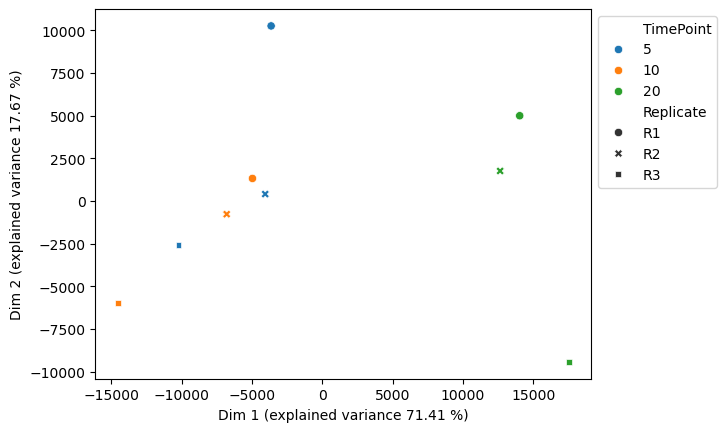

In [20]:
txPCA(tpms[columnOrder])

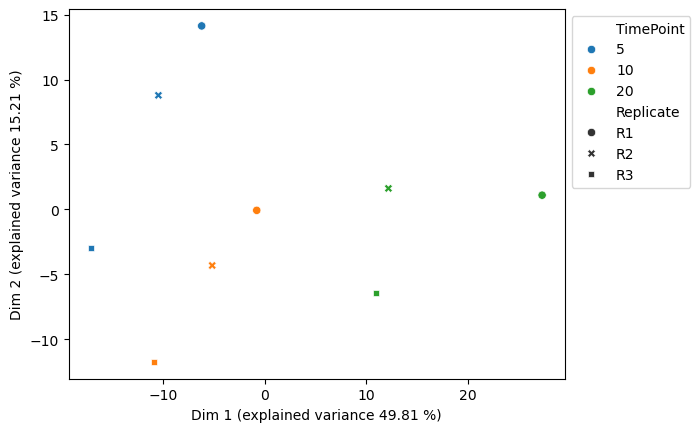

In [21]:
txPCA(logTPMs[columnOrder])

In [22]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

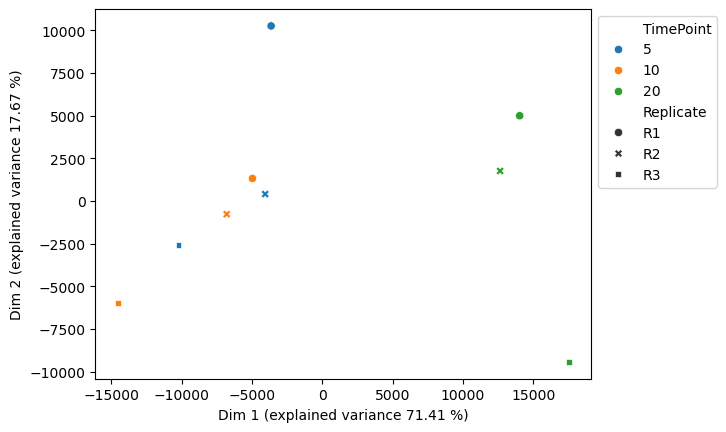

In [23]:
txPCA(tpmHost[columnOrder])

tpmPhage

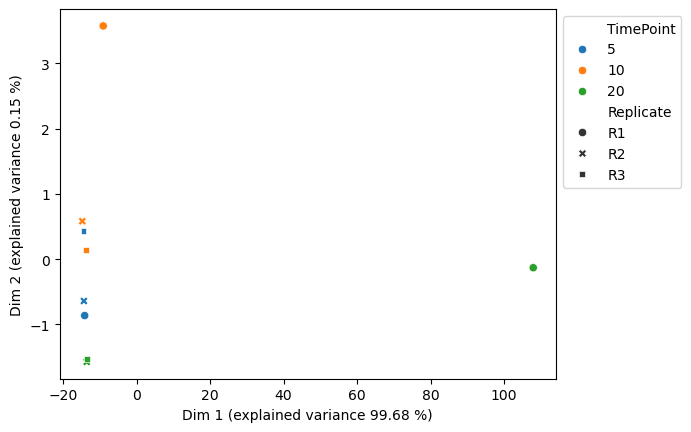

In [24]:
txPCA(tpmPhage[columnOrder])

logTPM Host

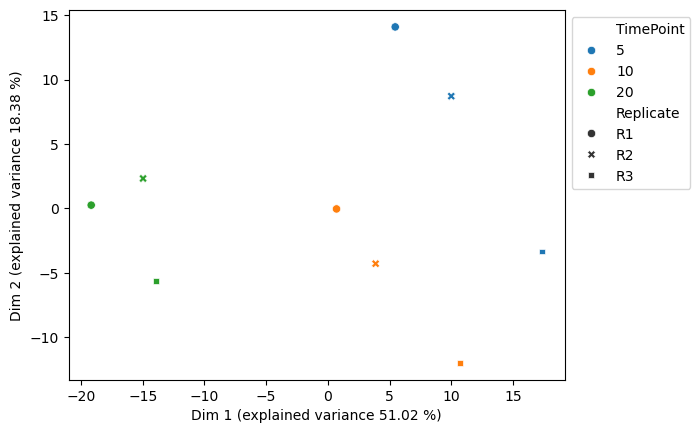

In [25]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

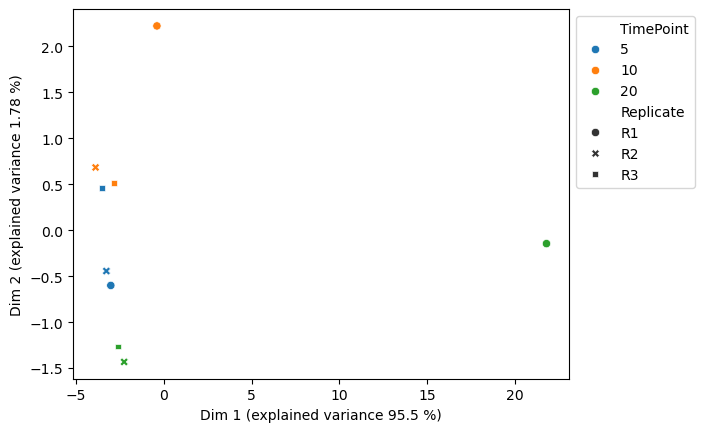

In [26]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Remove 20_R1, significant amount of counts for phage genes, although ctrl group. Other counts look fine.

In [27]:
updatedOrder = ['5_R1', '5_R2', '5_R3', '10_R1', '10_R2', '10_R3', '20_R2', '20_R3']

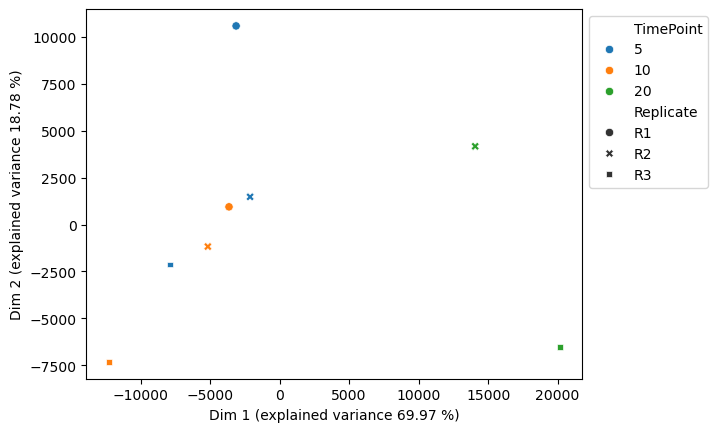

In [28]:
txPCA(tpms[updatedOrder])

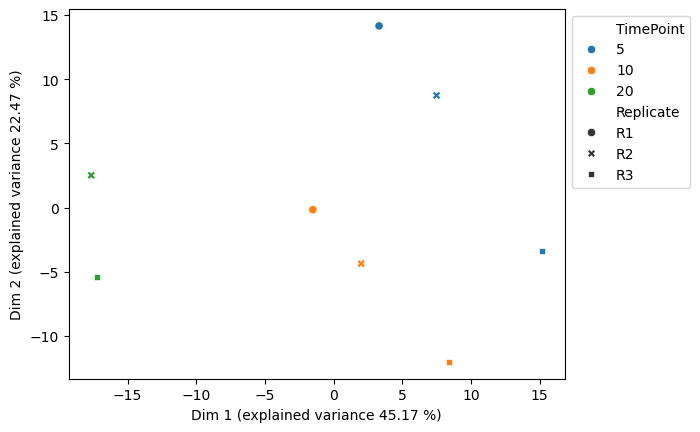

In [29]:
txPCA(logTPMs[updatedOrder])

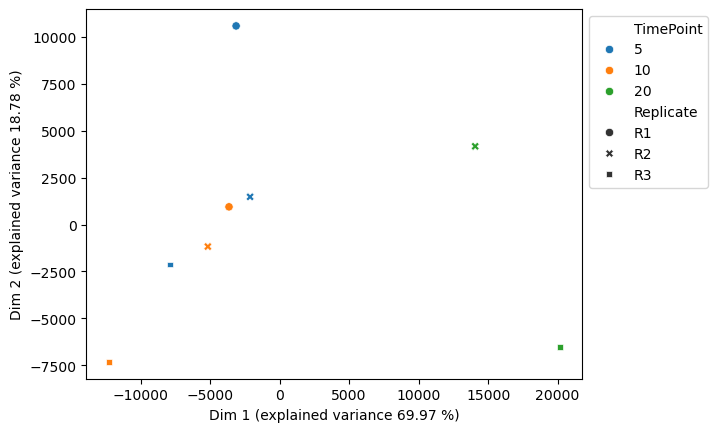

In [30]:
txPCA(tpmHost[updatedOrder])

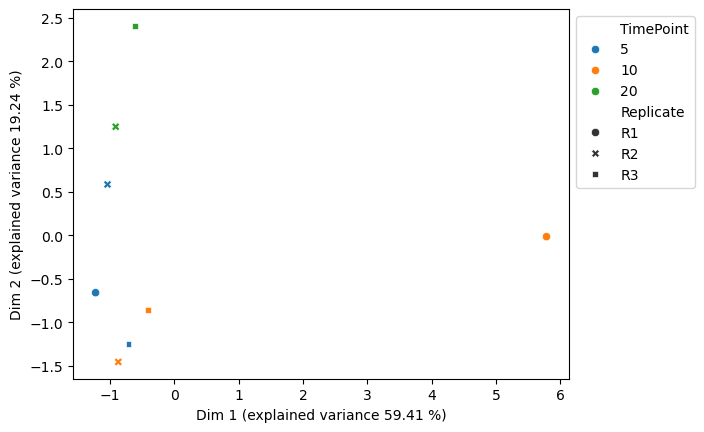

In [31]:
txPCA(tpmPhage[updatedOrder])

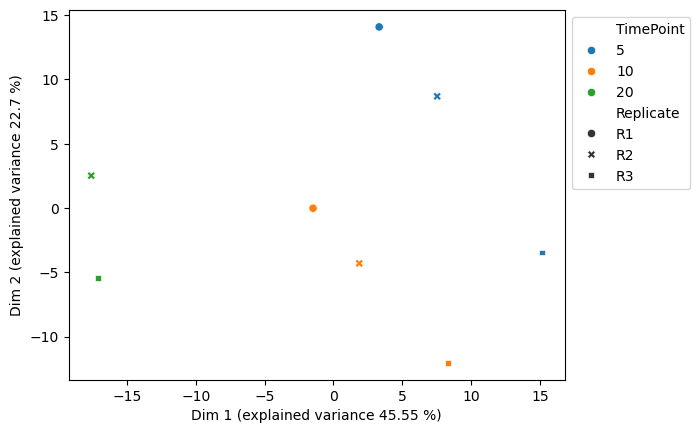

In [32]:
txPCA(logTPMsHost[updatedOrder])

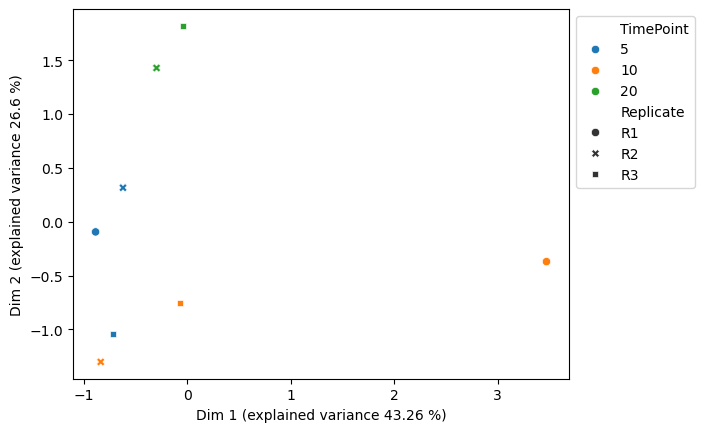

In [33]:
txPCA(logTPMsPhage[updatedOrder])

Better, 10_R1 debatable, but when looking on countsTable, its fine, some counts present, but not as drastic as in 20_R1.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [34]:
tpmsUpdated = tpms.drop(columns=['20_R1'], axis = 1)

In [35]:
TPMmeans, TPMsds = getMeanSD(tpmsUpdated[updatedOrder])
TPMmeans = TPMmeans[['5', '10', '20']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,5,10,20,Entity,Symbol
Geneid,,,,,
gene-AUO97_RS19195,83.290417,77.063997,48.981365,host,csuD
gene-AUO97_RS10905,0.253485,0.115749,0.308056,host,gene-AUO97_RS10905
gene-AUO97_RS12300,18.136607,11.784577,9.689211,host,gene-AUO97_RS12300
gene-AUO97_RS11260,118.836190,93.416010,69.768559,host,scpB
gene-AUO97_RS16080,29.120441,21.896662,20.769002,host,gene-AUO97_RS16080
...,...,...,...,...,...
gene-AUO97_RS12700,32.343496,25.298380,27.172386,host,gene-AUO97_RS12700
gene-AUO97_RS12635,0.062487,0.235661,0.059894,host,gene-AUO97_RS12635
gene-AUO97_RS13845,70.129595,80.624553,257.351050,host,gene-AUO97_RS13845


In [36]:
TPMsds = TPMsds[['5', '10', '20']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,5,10,20,Entity,Symbol
Geneid,,,,,
gene-AUO97_RS19195,7.498299,6.037953,4.718800,host,csuD
gene-AUO97_RS10905,0.133986,0.002195,0.170176,host,gene-AUO97_RS10905
gene-AUO97_RS12300,2.865251,1.720390,0.763648,host,gene-AUO97_RS12300
gene-AUO97_RS11260,5.880430,1.991895,2.927528,host,scpB
gene-AUO97_RS16080,3.205210,2.871096,1.880602,host,gene-AUO97_RS16080
...,...,...,...,...,...
gene-AUO97_RS12700,6.348244,1.853486,2.917160,host,gene-AUO97_RS12700
gene-AUO97_RS12635,0.003030,0.134534,0.004338,host,gene-AUO97_RS12635
gene-AUO97_RS13845,26.204553,27.785468,66.269372,host,gene-AUO97_RS13845


In [37]:
propExp = proportionalExp(TPMmeans[['5', '10', '20']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,5,10,20,Entity,Symbol
Geneid,,,,,
gene-AUO97_RS19195,1.000000,0.925244,0.588079,host,csuD
gene-AUO97_RS10905,0.822854,0.375741,1.000000,host,gene-AUO97_RS10905
gene-AUO97_RS12300,1.000000,0.649767,0.534235,host,gene-AUO97_RS12300
gene-AUO97_RS11260,1.000000,0.786091,0.587099,host,scpB
gene-AUO97_RS16080,1.000000,0.751934,0.713210,host,gene-AUO97_RS16080
...,...,...,...,...,...
gene-AUO97_RS12700,1.000000,0.782178,0.840119,host,gene-AUO97_RS12700
gene-AUO97_RS12635,0.265156,1.000000,0.254153,host,gene-AUO97_RS12635
gene-AUO97_RS13845,0.272506,0.313286,1.000000,host,gene-AUO97_RS13845


## 5. Phage gene classification

In [38]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [39]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [40]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [41]:
TPMmeans

,5,10,20,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,
gene-AUO97_RS19195,83.290417,77.063997,48.981365,host,csuD,None,None
gene-AUO97_RS10905,0.253485,0.115749,0.308056,host,gene-AUO97_RS10905,None,None
gene-AUO97_RS12300,18.136607,11.784577,9.689211,host,gene-AUO97_RS12300,None,None
gene-AUO97_RS11260,118.836190,93.416010,69.768559,host,scpB,None,None
gene-AUO97_RS16080,29.120441,21.896662,20.769002,host,gene-AUO97_RS16080,None,None
...,...,...,...,...,...,...,...
gene-AUO97_RS12700,32.343496,25.298380,27.172386,host,gene-AUO97_RS12700,None,None
gene-AUO97_RS12635,0.062487,0.235661,0.059894,host,gene-AUO97_RS12635,None,None
gene-AUO97_RS13845,70.129595,80.624553,257.351050,host,gene-AUO97_RS13845,None,None


In [42]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
middle    24
late      20
early     10
Name: count, dtype: int64

Add classes to other dfs.

In [43]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpmsUpdated[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NZ_CP018664.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_021316.1']
gff3_genes["seq_id"].unique()

array(['NZ_CP018664.1', 'NC_021316.1'], dtype=object)

## 6. Add variance to all dataframes

Base variance call on tpms.

In [44]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [45]:
tpmsUpdated

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R2,20_R3,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,,,,
gene-AUO97_RS19195,82.002182,93.050019,74.819049,69.284716,84.002801,77.904473,53.700165,44.262566,host,csuD,None,None
gene-AUO97_RS10905,0.442819,0.165370,0.152267,0.116828,0.112689,0.117731,0.478232,0.137881,host,gene-AUO97_RS10905,None,None
gene-AUO97_RS12300,21.575802,18.272662,14.561357,13.835164,11.893275,9.625293,8.925563,10.452859,host,gene-AUO97_RS12300,None,None
gene-AUO97_RS11260,114.636033,127.152232,114.720305,91.378232,92.750540,96.119258,72.696087,66.841031,host,scpB,None,None
gene-AUO97_RS16080,33.300279,28.549327,25.511715,23.143830,24.619451,17.926703,22.649604,18.888399,host,gene-AUO97_RS16080,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS12700,37.464459,36.169101,23.396928,27.452292,25.515106,22.927741,30.089546,24.255226,host,gene-AUO97_RS12700,None,None
gene-AUO97_RS12635,0.059475,0.066633,0.061353,0.329515,0.045406,0.332061,0.064231,0.055556,host,gene-AUO97_RS12635,None,None
gene-AUO97_RS13845,100.112179,74.001000,36.275606,103.503842,96.851711,41.518105,323.620422,191.081678,host,gene-AUO97_RS13845,None,None


In [46]:
tpmsUpdated = stabilizedVariance(tpmsUpdated)
tpmsUpdated

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R2,20_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,
gene-AUO97_RS19195,82.002182,93.050019,74.819049,69.284716,84.002801,77.904473,53.700165,44.262566,host,csuD,None,None,3.178616
gene-AUO97_RS10905,0.442819,0.165370,0.152267,0.116828,0.112689,0.117731,0.478232,0.137881,host,gene-AUO97_RS10905,None,None,0.094618
gene-AUO97_RS12300,21.575802,18.272662,14.561357,13.835164,11.893275,9.625293,8.925563,10.452859,host,gene-AUO97_RS12300,None,None,1.254129
gene-AUO97_RS11260,114.636033,127.152232,114.720305,91.378232,92.750540,96.119258,72.696087,66.841031,host,scpB,None,None,3.973839
gene-AUO97_RS16080,33.300279,28.549327,25.511715,23.143830,24.619451,17.926703,22.649604,18.888399,host,gene-AUO97_RS16080,None,None,0.897236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-AUO97_RS12700,37.464459,36.169101,23.396928,27.452292,25.515106,22.927741,30.089546,24.255226,host,gene-AUO97_RS12700,None,None,0.997726
gene-AUO97_RS12635,0.059475,0.066633,0.061353,0.329515,0.045406,0.332061,0.064231,0.055556,host,gene-AUO97_RS12635,None,None,0.109716
gene-AUO97_RS13845,100.112179,74.001000,36.275606,103.503842,96.851711,41.518105,323.620422,191.081678,host,gene-AUO97_RS13845,None,None,65.148614


In [47]:
TPMmeans['Variance'] = tpmsUpdated['Variance']
TPMsds['Variance'] = tpmsUpdated['Variance']
propExp['Variance'] = tpmsUpdated['Variance']

## 7. Write data to output

In [48]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAsUpdated = df_norRNAs.drop(columns=['20_R1'], axis=1)

In [49]:
df_norRNAs[df_norRNAs['Entity'] == 'phage']

SampleNames,5_R1,5_R2,5_R3,10_R1,10_R2,10_R3,20_R1,20_R2,20_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-M172_gp25,1,0,0,2,0,1,69,0,1,phage,gene-M172_gp25
gene-M172_gp27,0,0,1,1,0,0,34,4,1,phage,gene-M172_gp27
gene-M172_gp47,0,2,1,4,0,5,94,0,0,phage,gene-M172_gp47
gene-M172_gp10,0,0,0,4,0,1,33,1,1,phage,gene-M172_gp10
gene-M172_gp45,1,1,0,7,4,2,149,0,0,phage,gene-M172_gp45
gene-M172_gp31,0,0,0,2,0,0,23,1,0,phage,gene-M172_gp31
gene-M172_gp46,0,0,0,13,1,8,157,0,0,phage,gene-M172_gp46
gene-M172_gp42,0,2,0,4,1,2,34,0,0,phage,gene-M172_gp42
gene-M172_gp05,4,0,0,1,0,1,27,1,1,phage,gene-M172_gp05


In [50]:
# Full TPM table
tpmsUpdated.to_csv('Yang_ctrl_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAsUpdated.to_csv('Yang_ctrl_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Yang_ctrl_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Yang_ctrl_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Yang_ctrl_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Yang_ctrl_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Yang_ctrl_phage_gff3.tsv', sep='\t')